As an example of working with **Time Series** data, let’s take a look at bicycle counts on **Seattle’s Fremont Bridge**. This data comes from an automated bicycle counter, installed in late 2012, which has inductive sensors on the `east` and `west` sidewalks of the bridge. The hourly bicycle counts can be downloaded from [here](https://raw.githubusercontent.com/amankharwal/Fremont-Bridge-Bicycle-Counts/master/fremont-bridge.csv).

We will use **Pandas** to read to csv file and specify `Date` column as an **index**, and we want these dates to be automatically parsed:

In [1]:
import pandas as pd
data = pd.read_csv("fremont-bridge.csv", index_col= 'Date', parse_dates = True)
data.head()

,West,East
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0
2012-10-03 02:00:00,1.0,1.0
2012-10-03 03:00:00,2.0,3.0
2012-10-03 04:00:00,6.0,1.0


In [2]:
data.index.name = None

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45984 entries, 2012-10-03 00:00:00 to 2017-12-31 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   West    45976 non-null  float64
 1   East    45976 non-null  float64
dtypes: float64(2)
memory usage: 1.1 MB


In [4]:
data.isnull().sum()

West    8
East    8
dtype: int64

In [5]:
# Adding a “Total” column:

data["Total"] = data["West"] + data["East"] 
data.head()

,West,East,Total
2012-10-03 00:00:00,4.0,9.0,13.0
2012-10-03 01:00:00,4.0,6.0,10.0
2012-10-03 02:00:00,1.0,1.0,2.0
2012-10-03 03:00:00,2.0,3.0,5.0
2012-10-03 04:00:00,6.0,1.0,7.0


In [6]:
#  summary statistics

data.dropna().describe()

,West,East,Total
count,45976.000000,45976.000000,45976.000000
mean,54.712306,55.479315,110.191622
std,72.935797,80.232055,139.189603
min,0.000000,0.000000,0.000000
25%,7.000000,7.000000,15.000000
50%,29.000000,28.000000,60.000000
75%,72.000000,68.000000,144.000000
max,854.000000,717.000000,1165.000000


### Visualizing the data

We can gain some insight into the dataset by visualizing it. Let’s start by plotting the raw data:

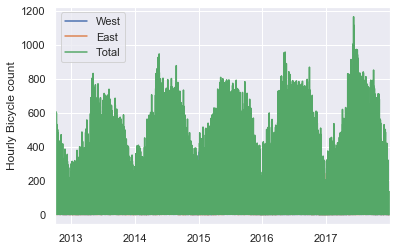

In [7]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
data.plot()
plt.ylabel("Hourly Bicycle count")
plt.show()

The hourly samples are far too dense for us to make much sense of. We can gain more insight by resampling the data to a `coarser grid`. Let’s resample by `week`:

In [17]:
data.resample("W").sum() # sum data on weekly basis (7 days basis)

,West,East,Total
2012-10-07,7297.0,6995.0,14292.0
2012-10-14,8679.0,8116.0,16795.0
2012-10-21,7946.0,7563.0,15509.0
2012-10-28,6901.0,6536.0,13437.0
2012-11-04,6408.0,5786.0,12194.0
...,...,...,...
2017-12-03,5668.0,8355.0,14023.0
2017-12-10,6229.0,9012.0,15241.0
2017-12-17,5496.0,8086.0,13582.0
2017-12-24,3685.0,5332.0,9017.0


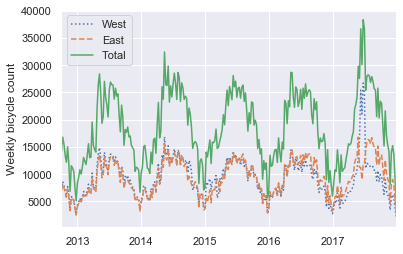

In [9]:
weekly = data.resample("W").sum()
weekly.plot(style=[':', '--', '-'])
plt.ylabel('Weekly bicycle count')
plt.show()

This shows us some interesting seasonal trends: as we might expect, people bicycle more in the summer than in the winter, and even within a particular season the bicycle use varies from week to week.

Another way that comes in handy for aggregating the data is to use a rolling mean, utilizing the `pd.rolling_mean()` function. Here we’ll do a **30-day** rolling mean of our data, making sure to `center` the window:

In [10]:
daily = data.resample('D').sum()

# daily.rolling(window = 6, center = True).sum()

# window = 6  will generate 5 Null rows
# center =  True will help create one null row from up
# and one null row from down unless 5 null rows genrated
# if center = False, then all null rows were generated from up

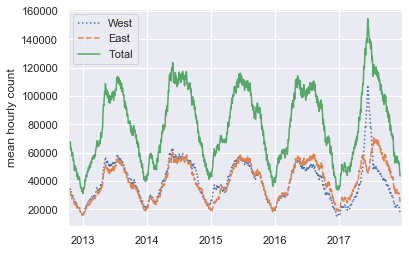

In [11]:
daily.rolling(30, center=True).sum().plot(style=[':', '--', '-'])
plt.ylabel('mean hourly count')
plt.show()

The jaggedness of the result is due to the hard cutoff of the window. We can get a smoother version of a rolling mean using a window function—for example, a `Gaussian` window.

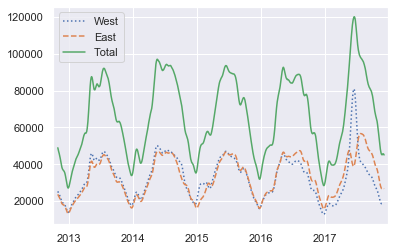

In [12]:
daily.rolling(50, center=True,
              win_type='gaussian').sum(std=10).plot(style=[':','--', '-'])
plt.show()

### Digging into the data

While the smoothed data views are useful to get an idea of the general trend in the data, they hide much of the interesting structure. For example, we might want to look at the average traffic as a function of the `time of day`. We can do this using the **GroupBy** functionality:

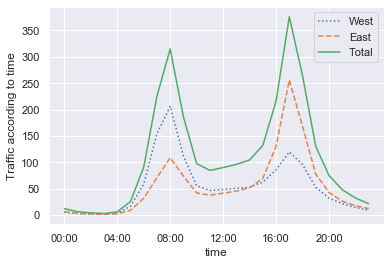

In [13]:
import numpy as np
by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks= hourly_ticks, style=[':', '--', '-'])
plt.ylabel("Traffic according to time")
plt.show()